<a href="https://colab.research.google.com/github/avnisinngh/Numpy-Learning/blob/main/segmentation_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [78]:
np.random.seed(42)

In [79]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [80]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [81]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [84]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 128, 128,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_12… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_57[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [85]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [86]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [87]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [89]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x


In [93]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)

    return dataset

In [94]:
batch_size = 16
lr = 1e-4
num_epochs = 300
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/brain_tumor_dataset/final_data_set/"

In [95]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (34,34)
Valid: (11,11)
Test: (11,11)


In [96]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [97]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [98]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [99]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0,
    )


Epoch 1: val_loss improved from inf to 0.96402, saving model to files/model.h5



Epoch 2: val_loss improved from 0.96402 to 0.96377, saving model to files/model.h5



Epoch 3: val_loss improved from 0.96377 to 0.96355, saving model to files/model.h5



Epoch 4: val_loss improved from 0.96355 to 0.96338, saving model to files/model.h5



Epoch 5: val_loss improved from 0.96338 to 0.96331, saving model to files/model.h5



Epoch 6: val_loss improved from 0.96331 to 0.96330, saving model to files/model.h5



Epoch 7: val_loss did not improve from 0.96330

Epoch 8: val_loss did not improve from 0.96330

Epoch 9: val_loss did not improve from 0.96330

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 10: val_loss did not improve from 0.96330

Epoch 11: val_loss did not improve from 0.96330

Epoch 12: val_loss did not improve from 0.96330

Epoch 13: val_loss did not improve from 0.96330

Epoch 14: val_loss did not improve from 0.96330

Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 15: val_loss did not improve from 0.96330

Epoch 16: val_loss did not improve from 0.96330

Epoch 17: val_loss did not improve from 0.96330

Epoch 18: val_loss did not improve from 0.96330

Epoch 19: val_loss did not improve from 0.96330

Epoch 19: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 20: val_loss did not improve from 0.96330

Epoch 21: val_loss did not improve from 0.96330

Epoch 22: val_loss did not improve from 0.96330

E

In [101]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head(2)

,epoch,accuracy,dice_coef,learning_rate,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.365292,0.037039,0.0001,0.970127,0.643825,0.035979,0.964021
1,1,0.678726,0.054708,0.0001,0.949981,0.673682,0.036229,0.963771


<Axes: >

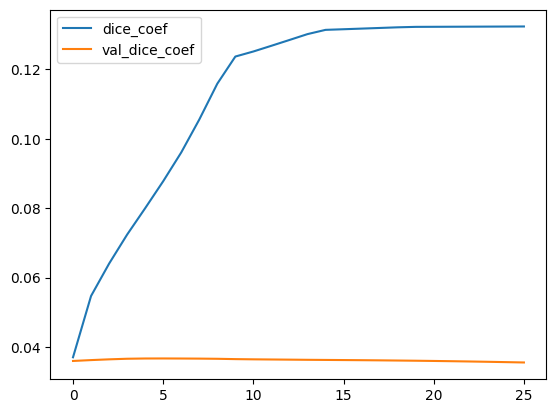

In [102]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

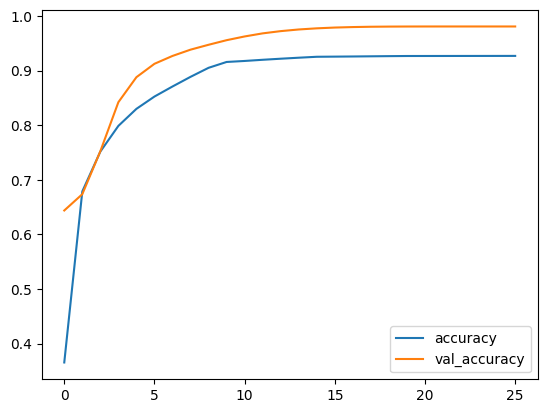

In [103]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

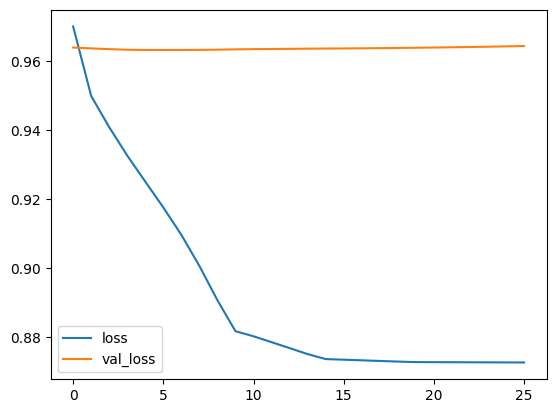

In [104]:
metrics[['loss','val_loss']].plot()

In [105]:
create_dir("results")

# with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
#     model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

In [106]:
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [107]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))
    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()
    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv", index=None)

  9%|▉         | 1/11 [00:14<02:20, 14.01s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 18%|█▊        | 2/11 [00:16<01:03,  7.06s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 27%|██▋       | 3/11 [00:18<00:40,  5.05s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 36%|███▋      | 4/11 [00:24<00:35,  5.14s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 45%|████▌     | 5/11 [00:29<00:31,  5.18s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 55%|█████▍    | 6/11 [00:32<00:21,  4.33s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 64%|██████▎   | 7/11 [00:35<00:16,  4.02s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 73%|███████▎  | 8/11 [00:38<00:10,  3.58s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 82%|████████▏ | 9/11 [00:40<00:06,  3.11s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


 91%|█████████ | 10/11 [00:42<00:02,  2.97s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


100%|██████████| 11/11 [00:44<00:00,  4.08s/it]

F1: 0.00000
Jaccard: 0.00000
Recall: 0.00000
Precision: 0.00000


In [108]:
scores = pd.read_csv("/content/files/score.csv")
scores.head(3)

,Image,F1,Jaccard,Recall,Precision
0,16.png,0.0,0.0,0.0,0.0
1,46.png,0.0,0.0,0.0,0.0
2,10.png,0.0,0.0,0.0,0.0


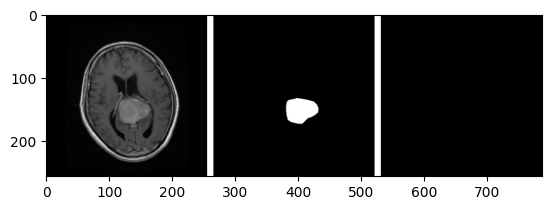

In [110]:
dir = "/content/results/"
images = os.listdir("/content/results")[:5]
img1 = plt.imread(dir+images[0])
plt.imshow(img1, cmap='gray')

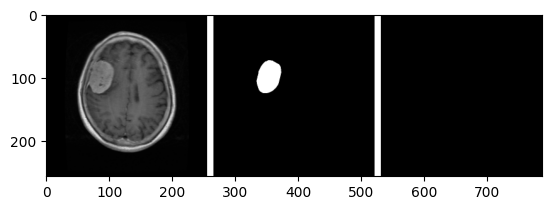

In [111]:
img1 = plt.imread(dir+images[2])
plt.imshow(img1, cmap='gray')